<a href="https://colab.research.google.com/github/CHIN-HUA/gcn_colab/blob/main/gcn_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/hengqujushi/gcn_colab

Cloning into 'gcn_colab'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 60 (delta 11), reused 57 (delta 10), pack-reused 0
Unpacking objects: 100% (60/60), 5.25 MiB | 1.73 MiB/s, done.


In [3]:
!python ./gcn_colab/setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [6]:

!cd ./gcn_colab/gcn && python train.py --dataset citeseer


2023-05-16 05:04:47.806690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 05:04:49.309722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/gcn_colab/gcn/utils.py:115: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()
2023-05-16 05:04:51.953129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_7' with dtype int32
	 [[{{node Placeholder_7}}]]
2023-05-16 05:04:51.953276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG 

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


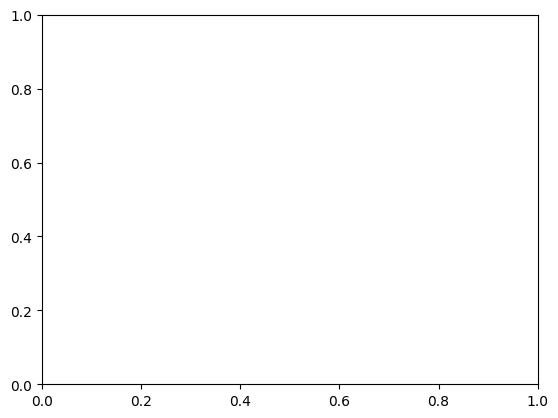

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA

x, y = [], []
with open("./gcn_colab/gcn/labels.txt", "r") as f:
    data1 = f.read().strip().split("\n")
    for i in data1:
        y.append(int(i))
with open("./gcn_colab/gcn/embeddings.txt", "r") as f:
    data1 = f.read().strip().split("\n")
    for item in data1:
        a = []
        item1 = item.split(" ")
        for i in item1:
            a.append(float(i))
        x.append(a)

pca = PCA(n_components=2)
reduced_x = pca.fit_transform(x)

color = ['blue', 'red']
fig, ax = plt.subplots()

def update(frame):
    ax.cla()
    for index, item in enumerate(reduced_x):
        if index < len(y):
            label_index = min(y[index], len(color) - 1)
            ax.scatter(item[0], item[1], c=color[label_index])
    ax.set_title("GCN Visualization")

ani = FuncAnimation(fig, update, frames=len(reduced_x), interval=200)
plt.show()


In [ ]:
import matplotlib.pyplot as plt                 #加载matplotlib用于数据的可视化
from sklearn.decomposition import PCA           #加载PCA算法包

x, y= [], []
with open("./gcn_colab/gcn/labels.txt", "r") as f:  # 打开文件
    data1 = f.read().strip().split("\n")  # 读取文件
    for i in data1:
        y.append(int(i))
with open("./gcn_colab/gcn/embeddings.txt", "r") as f:  # 打开文件
    data1 = f.read().strip().split("\n")  # 读取文件
    for item in data1:
        a = []
        item1 = item.split(" ")
        for i in item1:
            a.append(float(i))
        x.append(a)

pca=PCA(n_components=2)     #加载PCA算法，设置降维后主成分数目为2
reduced_x=pca.fit_transform(x)#对样本进行降维
print(reduced_x)

# #可视化
color = ['blue', 'red']
for index, item in enumerate(reduced_x):
    label_index = min(y[index], len(color) - 1)
    plt.scatter(item[0], item[1], c=color[label_index])
plt.show()



[[-0.02969309  1.92668251]
 [-2.87816948 -1.51689346]
 [ 5.31122672 -1.60693644]
 ...
 [-0.6515273   2.00398085]
 [-0.96841437 -1.45814141]
 [ 1.08727754 -2.01871838]]
